In [2]:
import json
import torch
import random
import pathlib
import numpy as np
import torchvision.utils as vutils
import torchvision.transforms as T
from matplotlib import pyplot as plt
from PIL import Image, ImageFont, ImageDraw
from einops import rearrange, reduce, repeat
from torch import BoolTensor, FloatTensor, LongTensor
from typing import Dict, List, Optional, Tuple, Union

In [3]:
def convert_layout_to_image(
    boxes: FloatTensor,
    labels: LongTensor,
    colors: List[Tuple[int]],
    canvas_size: Optional[Tuple[int]] = (60, 40),
    resources: Optional[Dict] = None,
    names: Optional[Tuple[str]] = None,
    index: bool = False,
    **kwargs,
):
    H, W = canvas_size
    if names or index:
        # font = ImageFont.truetype("LiberationSerif-Regular", W // 10)
        font = ImageFont.load_default()

    if resources:
        img = resources["img_bg"].resize((W, H))
    else:
        img = Image.new("RGB", (int(W), int(H)), color=(255, 255, 255))
    draw = ImageDraw.Draw(img, "RGBA")
    
    for i in range(boxes.shape[0]):
        bbox, label = boxes[i], labels[i]
        if isinstance(label, LongTensor):
            label = label.item()

        c_fill = colors[label] + (100,)
        x1, y1, x2, y2 = bbox
        x1, x2 = x1 * (W - 1), x2 * (W - 1)
        y1, y2 = y1 * (H - 1), y2 * (H - 1)

        if resources:
            patch = resources["cropped_patches"][i]
            # round coordinates for exact size match for rendering images
            x1, x2 = int(x1), int(x2)
            y1, y2 = int(y1), int(y2)
            w, h = x2 - x1, y2 - y1
            patch = patch.resize((w, h))
            img.paste(patch, (x1, y1))
        else:
            draw.rectangle([x1, y1, x2, y2], outline=colors[label], fill=c_fill)
            if names:
                # draw.text((x1, y1), names[label], colors[label], font=font)
                draw.text((x1, y1), names[label], "black", font=font)
            elif index:
                draw.text((x1, y1), str(int(i % (len(labels)/2))), "black", font=font)

    return img

In [4]:
def save_image(
    batch_boxes: FloatTensor,
    batch_labels: LongTensor,
    batch_mask: BoolTensor,
    out_path: Optional[Union[pathlib.PosixPath, str]] = None,
    canvas_size: Optional[Tuple[int]] = (360, 240),
    nrow: Optional[int] = None,
    batch_resources: Optional[Dict] = None,
    use_grid: bool = True,
    draw_label: bool = False,
    draw_index: bool = False,
    dataset: str = 'publaynet'
):
    # batch_boxes: [B, N, 4]
    # batch_labels: [B, N]
    # batch_mask: [B, N]

    if isinstance(out_path, pathlib.PosixPath):
        out_path = str(out_path)

    color_6 = ((246, 112, 136), (173, 156, 49), (51, 176, 122), (56, 168, 197), (204, 121, 244), (204, 50, 144))
    colors = color_6

    if not draw_label:
        names = None
    else:
        names = ["text", "title", "list", "table", "figure"]

    imgs = []
    B = batch_boxes.size(0)
    to_tensor = T.ToTensor()
    for i in range(B):
        mask_i = batch_mask[i]
        boxes = batch_boxes[i][mask_i]
        labels = batch_labels[i][mask_i]
        if batch_resources:
            resources = {k: v[i] for (k, v) in batch_resources.items()}
            img = convert_layout_to_image(boxes, labels, colors, canvas_size, resources, names=names, index=draw_index)
        else:
            img = convert_layout_to_image(boxes, labels, colors, canvas_size, names=names, index=draw_index)
        imgs.append(to_tensor(img))
    image = torch.stack(imgs)

    if nrow is None:
        nrow = int(np.ceil(np.sqrt(B)))

    if out_path:
        vutils.save_image(image, out_path, normalize=False, nrow=nrow)
    else:
        if use_grid:
            return torch_to_numpy_image(
                vutils.make_grid(image, normalize=False, nrow=nrow)
            )
        else:
            return image

In [5]:
def torch_to_numpy_image(input_th: FloatTensor) -> np.ndarray:
    """
    Args
        input_th: (C, H, W), in [0.0, 1/0], torch image
    Returns
        output_npy: (H, W, C), in {0, 1, ..., 255}, numpy image
    """
    x = (input_th * 255.0).clamp(0, 255)
    x = rearrange(x, "c h w -> h w c")
    output_npy = x.numpy().astype(np.uint8)
    return output_npy

### visualize layout

In [5]:
layout_all = json.load(open("output-diffusion_processed.json"))

In [43]:
# batch_size = 9
# batch_bbox, batch_category, batch_mask = [], [], []
# for batch in range(batch_size):
#     layout = random.choice(layout_all)
#     bbox, category = layout["boxes"], layout["categories"]
#     bbox = torch.Tensor(bbox)
#     real_bbox = torch.zeros(25,4)
#     real_bbox[:bbox.shape[0]] = bbox
#     real_category = torch.ones(25)*5
#     category = torch.Tensor(category)
#     real_category[:category.shape[0]] = category
#     real_mask = torch.ones(25).bool()
#     real_mask[bbox.shape[0]:] = False
#     batch_bbox.append(real_bbox.unsqueeze(0))
#     batch_category.append(real_category.unsqueeze(0))
#     batch_mask.append(real_mask.unsqueeze(0))
# batch_bbox = torch.cat(batch_bbox, dim=0)
# batch_category = torch.cat(batch_category, dim=0).long()
# batch_mask = torch.cat(batch_mask, dim=0)
batch_size = 2
index_all = [274,800]
batch_bbox, batch_category, batch_mask = [], [], []
for batch in range(batch_size):
    layout = layout_all[index_all[batch]]
    bbox, category = layout["boxes"], layout["categories"]
    bbox = torch.Tensor(bbox)
    real_bbox = torch.zeros(25,4)
    real_bbox[:bbox.shape[0]] = bbox
    real_category = torch.ones(25)*5
    category = torch.Tensor(category)
    real_category[:category.shape[0]] = category
    real_mask = torch.ones(25).bool()
    real_mask[bbox.shape[0]:] = False
    batch_bbox.append(real_bbox.unsqueeze(0))
    batch_category.append(real_category.unsqueeze(0))
    batch_mask.append(real_mask.unsqueeze(0))
batch_bbox = torch.cat(batch_bbox, dim=0)
batch_category = torch.cat(batch_category, dim=0).long()
batch_mask = torch.cat(batch_mask, dim=0)

In [44]:
batch_image = save_image(batch_bbox, batch_category, batch_mask, draw_label=True)

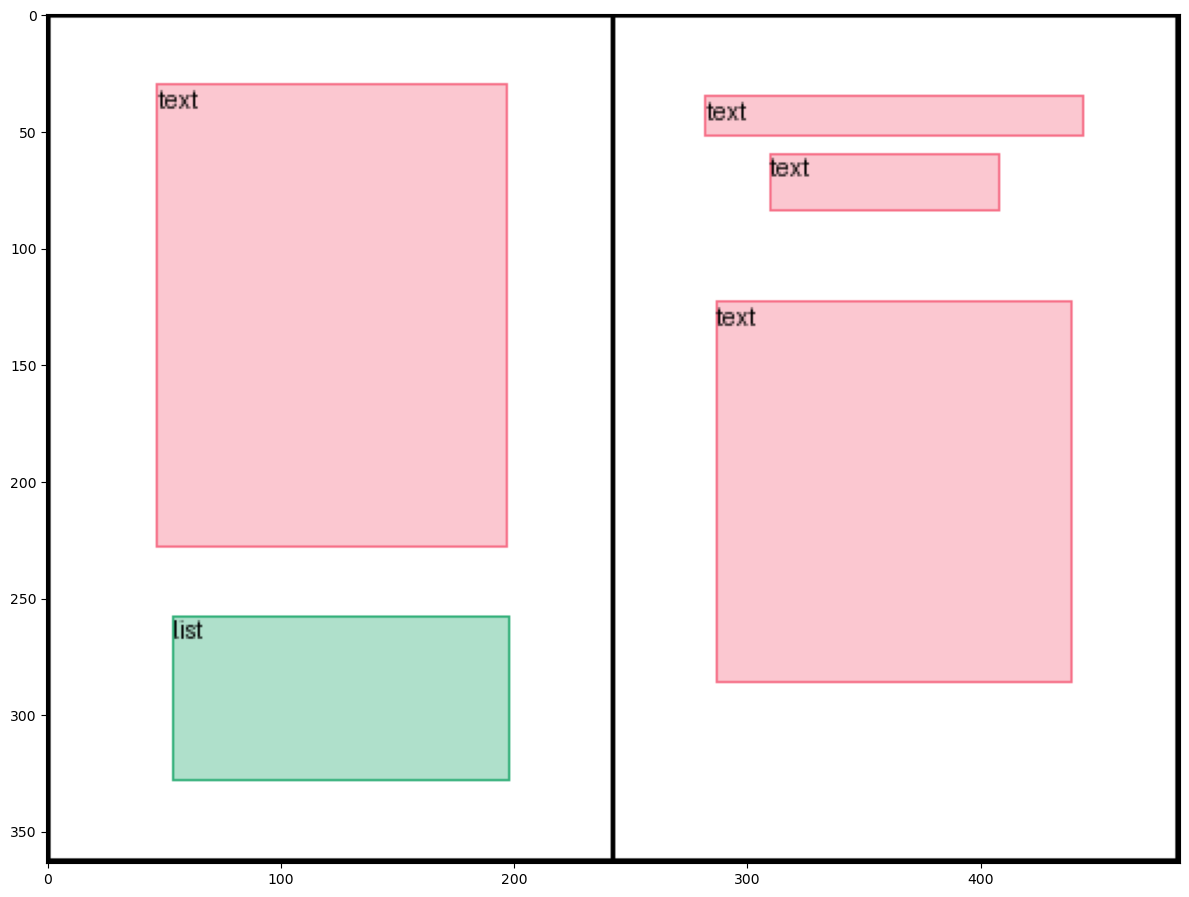

In [45]:
plt.figure(figsize=[12, 12])
plt.imshow(batch_image)
plt.tight_layout()
plt.savefig("test.png")

### visualize rendered layout

In [6]:
def convert_single_layout_to_image(
    img,
    boxes,
    labels,
    names=["text", "title", "table", "figure"],
):
    color_6 = ((246, 112, 136), (173, 156, 49), (51, 176, 122), (56, 168, 197), (204, 121, 244), (204, 50, 144))
    colors = color_6
    
    font = ImageFont.load_default()
    draw = ImageDraw.Draw(img, "RGBA")
    
    for i in range(len(boxes)):
        bbox, label = boxes[i], labels[i]
        x1, y1, x2, y2 = bbox

        c = tuple(colors[label])
        c_fill = c + (100,)
        draw.rectangle([x1, y1, x2, y2], outline=c, width=3, fill=c_fill)
        if names:
            # draw.text((x1, y1), names[label], colors[label], font=font)
            draw.text((x1, y1), names[label], "black", font=font)
        elif index:
            draw.text((x1, y1), str(int(i % (len(labels)/2))), "black", font=font)

    return img

In [8]:
import os

In [10]:
_set = "bestfit"

In [11]:
print(os.listdir(f"/mnt/hwfile/opendatalab/zhaozhiyuan/pretrain_layout/{_set}_layout/images")[:100])

[]


In [87]:
_id = "1718937528_9312963"
_set = "bestfitv2"
image = Image.open(f"/mnt/hwfile/opendatalab/zhaozhiyuan/pretrain_layout/{_set}_layout/images/{_id}.jpg")
anno = json.load(open(f"/mnt/hwfile/opendatalab/zhaozhiyuan/pretrain_layout/{_set}_layout/labels/{_id}.json"))
boxes, labels = anno["bbox"], anno["labels"]
image = convert_single_layout_to_image(image, boxes, labels)

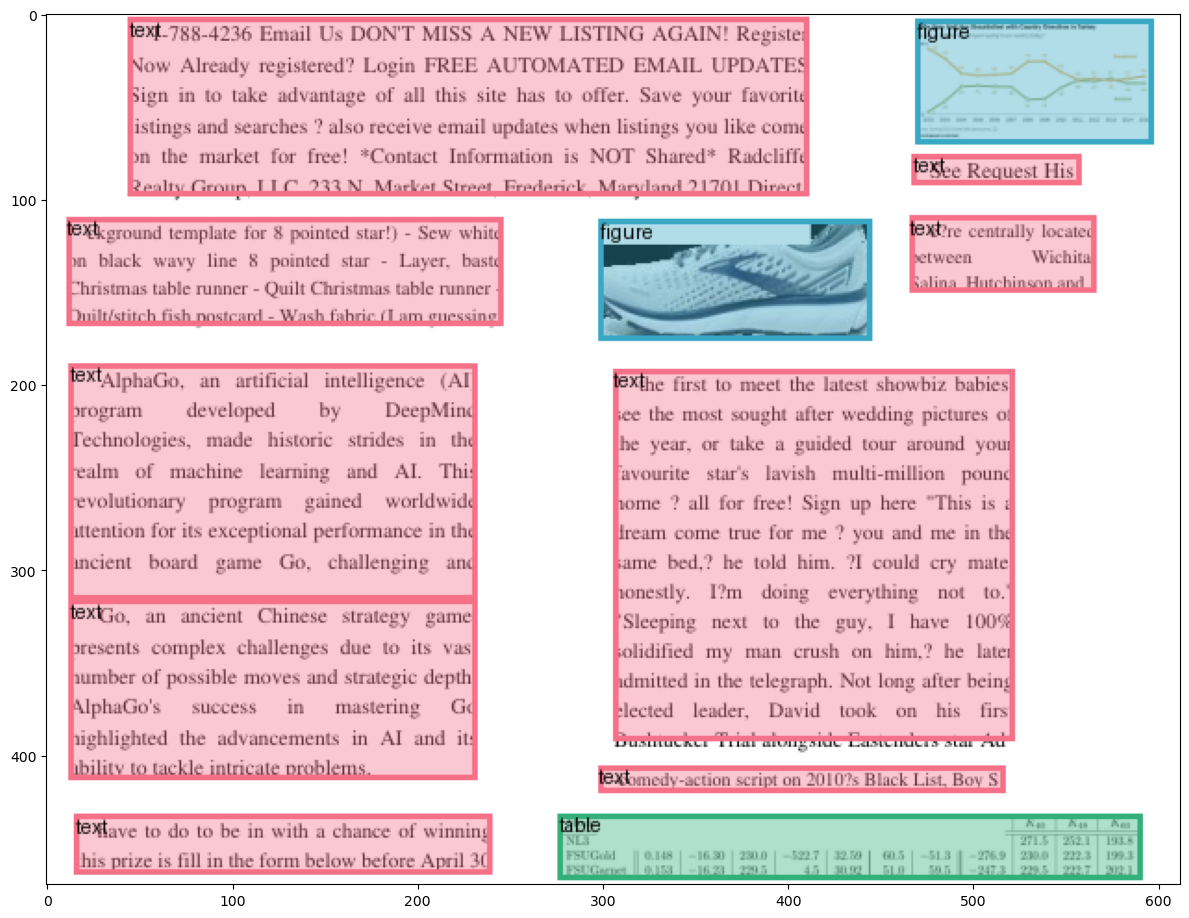

In [88]:
plt.figure(figsize=[12, 12])
plt.imshow(image)
plt.tight_layout()
plt.savefig("test.png")

### visualize rendered layout

In [133]:
_id = "1718938783_7307081"
_set = "bestfitv2"
image = Image.open(f"/mnt/hwfile/opendatalab/zhaozhiyuan/pretrain_layout/{_set}_layout/images/{_id}.jpg")

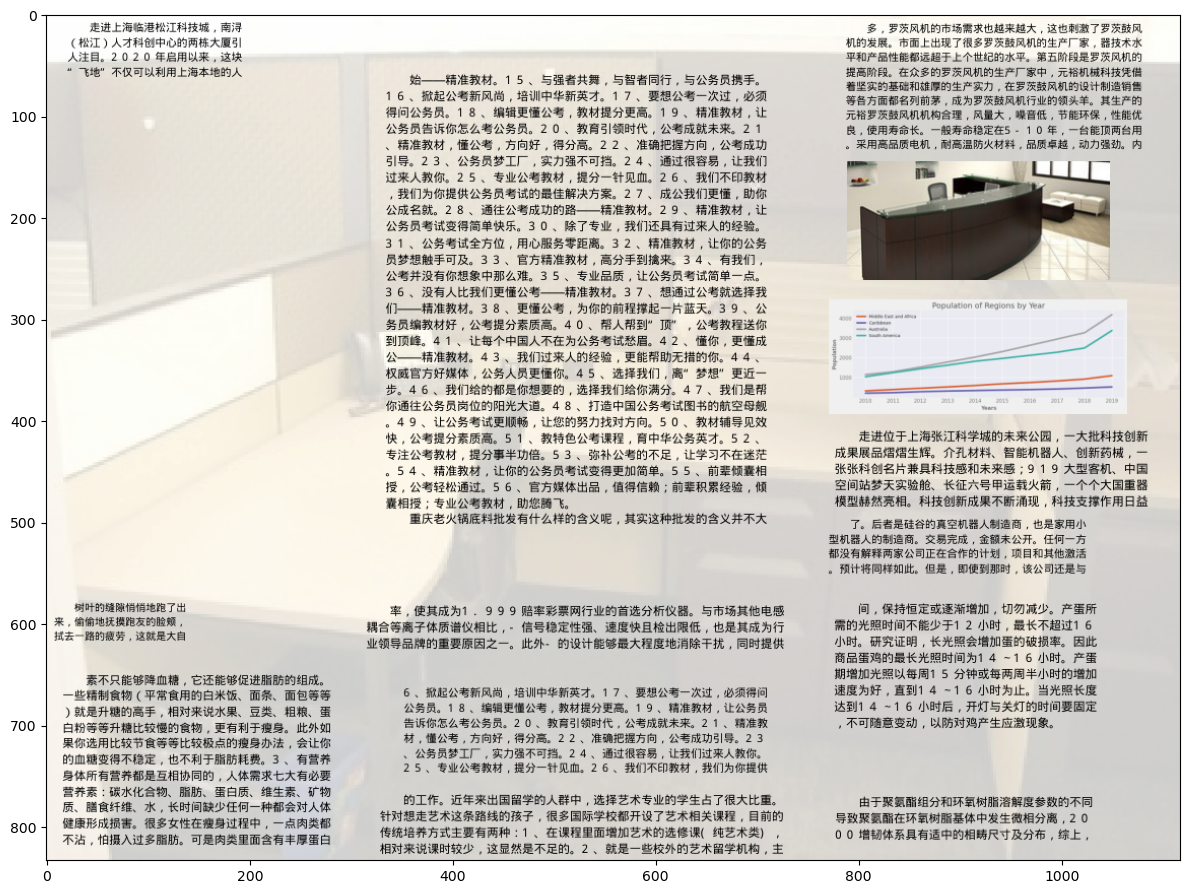

In [134]:
plt.figure(figsize=[12, 12])
plt.imshow(image)
plt.tight_layout()
plt.savefig("test.png")

### visualize rendered layout

In [174]:
import os
import random

In [175]:
base_path = "/mnt/hwfile/opendatalab/zhaozhiyuan/yolov10/bestfit_layout/images"
image_all = os.listdir(base_path)

In [185]:
image = Image.open(os.path.join(base_path, random.choice(image_all)))

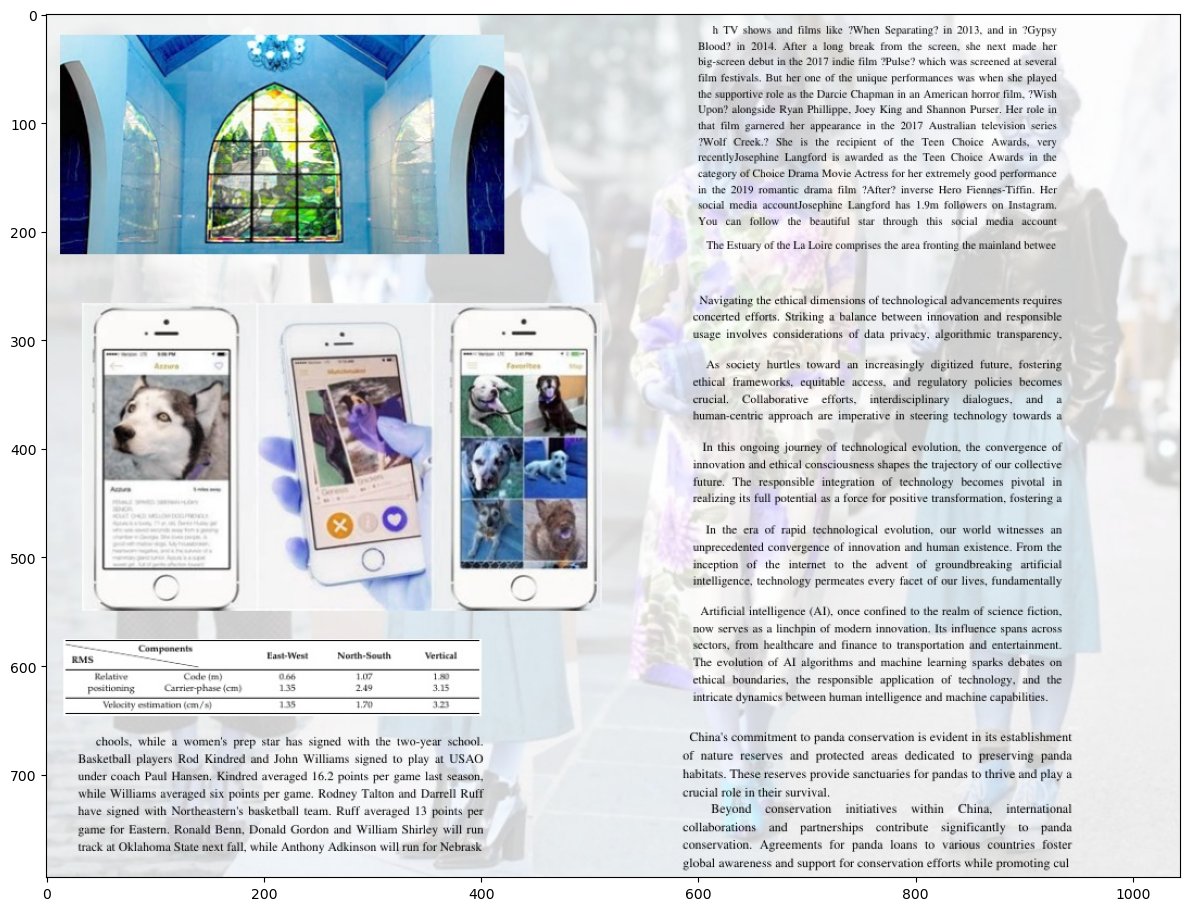

In [186]:
plt.figure(figsize=[12, 12])
plt.imshow(image)
plt.tight_layout()
plt.savefig("test.png")